# Analisando o bot

Este jupyter-notebook vai auxiliar na análise de um RASA bot.

## Instalação

### Configurando jupyter

In [1]:
%matplotlib inline

import logging, io, json, warnings
logging.basicConfig(level="INFO")
warnings.filterwarnings('ignore')

def pprint(o):
    # small helper to make dict dumps a bit prettier
    print(json.dumps(o, indent=2))

### Instalação do Rasa


Verificando versões:

In [2]:
import rasa_nlu
import spacy

print("rasa_nlu: {}".format(rasa_nlu.__version__))
print("Loading spaCy language model...")
print(spacy.load("pt")("Olá Mundo!"))

rasa_nlu: 0.13.7
Loading spaCy language model...
Olá Mundo!


### Treinando o modelo do Rasa NLU

Na celula abaixo todas as intents na pasta `../data/intents/` serão utilizadas para gerar os gráficos de avaliação do bot.

Ela irá treinar o modelo e executar a avaliação que pode ser verificada na saída da célula abaixo.

INFO:rasa_nlu.training_data.loading:Training data format of ../../bot/data/intents/processo.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 374 (14 distinct intents)
	- Found intents: 'processo_definicao_etapas', 'processo_aprovacao', 'processo', 'processo_preenchimento', 'processo_situacao_processo', 'processo_periodo', 'processo_reativacao_de_proposta', 'processo_prazo_envio_cnae', 'processo_prazo', 'processo_admissibilidade', 'processo_execucao', 'processo_analise_de_resultados', 'processo_prazo_desistir_recurso', 'processo_como_funciona'
	- entity examples: 257 (1 distinct entities)
	- found entities: 'situacao_processo'

INFO:rasa_nlu.training_data.loading:Training data format of ../../bot/data/intents/general.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 154 (10 distinct intents)
	- Found intents: 'diga_mais', 'tudo_bem', 'despedir', 'out_of_scope', 'erro_resposta_utter', 'afirmar', 'negar

INFO:rasa_nlu.training_data.loading:Training data format of ../../bot/data/intents/captacao.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 42 (3 distinct intents)
	- Found intents: 'captacao_quando_captar', 'captacao', 'captacao_como_captar'
	- entity examples: 0 (0 distinct entities)
	- found entities: 

INFO:rasa_nlu.training_data.loading:Training data format of ../../bot/data/intents/salic.md is md
INFO:rasa_nlu.training_data.training_data:Training data stats: 
	- intent examples: 104 (15 distinct intents)
	- Found intents: 'salic_preenchimento', 'salic_erros_vinculo_cpf_cnpj', 'salic_preenchimento_vinculo_cpf_proposta', 'salic_preenchimento_cadastro_agencia_bancaria', 'salic_erros_achar_proposta', 'salic_erros', 'salic_cadastro_proponente', 'salic_cadastro_usuario', 'salic_recuperacao_de_senha', 'salic_erros_planilha_desapareceu', 'salic', 'salic_preenchimento_valor_ingresso', 'salic_erros_salvamento_de_proposta', 'salic_preenchimento_c

INFO:rasa_nlu.evaluate:There were some nlu intent classification errors. Use `--verbose` to show them in the log.
INFO:rasa_nlu.evaluate:Model prediction errors saved to errors.json.
INFO:rasa_nlu.evaluate:Confusion matrix, without normalization: 
[[20  0  0 ...  0  0  1]
 [ 0  3  0 ...  0  0  0]
 [ 0  0 20 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  0  0]
 [ 0  0  0 ...  0 11  0]
 [ 0  0  0 ...  0  0  9]]


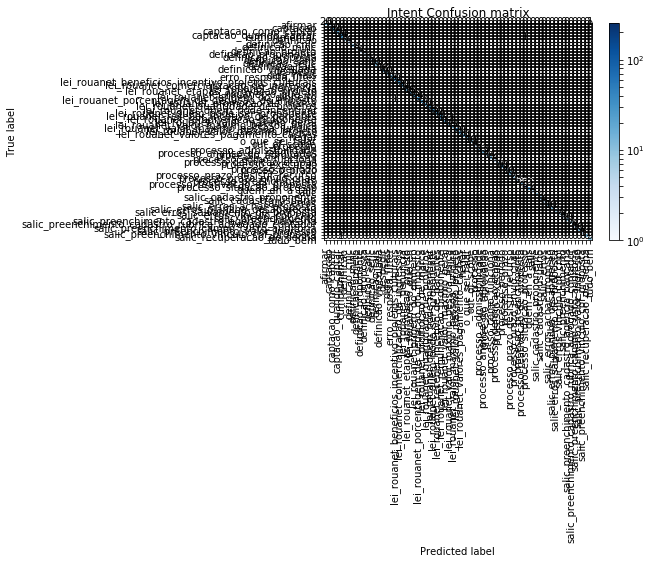

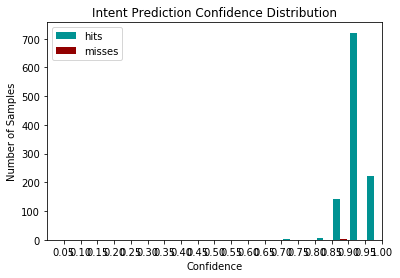

INFO:rasa_nlu.evaluate:Entity evaluation results:
INFO:rasa_nlu.evaluate:Evaluation for entity extractor: ner_crf 
INFO:rasa_nlu.evaluate:F1-Score:  0.9991826979902555
INFO:rasa_nlu.evaluate:Precision: 0.9992087423910946
INFO:rasa_nlu.evaluate:Accuracy:  0.9992080776083944
INFO:rasa_nlu.evaluate:Classification report: 
                   precision    recall  f1-score   support

      lei_rouanet       1.00      0.88      0.94        33
        no_entity       1.00      1.00      1.00      4761
situacao_processo       1.00      1.00      1.00       257

      avg / total       1.00      1.00      1.00      5051



In [3]:
import os

from rasa_nlu.training_data import load_data
from rasa_nlu.model import Trainer
from rasa_nlu import config


intents_directory = '../../bot/data/intents/'

intents = {}

for intent_file in os.listdir(intents_directory):
    intent_file_path = os.path.join(intents_directory, intent_file)

    intents[intent_file] = {}

    intent_list = []
    intent_name = None

    with open(intent_file_path) as f:
        lines = f.readlines()

        for line in lines:
            line = line.strip()

            if line.startswith('##'):
                if intent_name is not None:
                    intents[intent_file][intent_name] = intent_list
                intent_name = line.replace('## intent:', '') 
                intent_list = []

            elif line.startswith('- '):
                intent_list.append(line.replace('- ', ''))


# loading the nlu training samples
training_data = load_data(intents_directory)

# trainer to educate our pipeline
trainer = Trainer(config.load("../../bot/nlu_config.yml"))

# train the model!
interpreter = trainer.train(training_data)

# store it for future use
model_directory = trainer.persist("./models/nlu", fixed_model_name="current")

from rasa_nlu.evaluate import run_evaluation
run_evaluation('../../bot/data/intents/', model_directory)

### Avaliação do modelo de NLU treinado

`Caso queira testar mensagens específicas mande a mensagem na célula seguinte`

Quando quiser parar o teste diga **pare**

In [4]:
pprint(interpreter.parse('posso terceirizar a captação de recursos?'))

{
  "intent": {
    "name": "captacao_quando_captar",
    "confidence": 0.7346936464309692
  },
  "entities": [],
  "intent_ranking": [
    {
      "name": "captacao_quando_captar",
      "confidence": 0.7346936464309692
    },
    {
      "name": "captacao_como_captar",
      "confidence": 0.6702125668525696
    },
    {
      "name": "salic_erros_planilha_desapareceu",
      "confidence": 0.2790621519088745
    },
    {
      "name": "lei_rouanet_etapas_aprovacao_projeto",
      "confidence": 0.23622938990592957
    },
    {
      "name": "salic_erros_salvamento_de_proposta",
      "confidence": 0.23546817898750305
    },
    {
      "name": "salic_preenchimento",
      "confidence": 0.22779959440231323
    },
    {
      "name": "processo_analise_de_resultados",
      "confidence": 0.21793940663337708
    },
    {
      "name": "definicao_projeto",
      "confidence": 0.21623966097831726
    },
    {
      "name": "captacao",
      "confidence": 0.21158388257026672
    },
    {
    